# Feature Engineering & Feature Selection
A number supplemental features have been collected from an external source, `supplemental-stats.csv`. Normally, we'd have to hand craft these features. For example, we may have had the raw counts for pitcher's total strikes -- both swinging and looking. We could used these counts to produce the features 'L/Str': looking strike percentage (strikes looking / total strikes) and 'S/Str': swinging strike percentage (swinging strikes w/o contact / total strikes).

Since we have a pretty robust data set to start with after adding the supplemental data, we'll focus on preparing the features for model training and selecting the most predictive features.

**NOTE**: All pipelines and functions defined in this notebook are defined in source code at `bullpen.model_utils`. They are show here for convenience, but stored in source code for future use and ability to unit test.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="text")

from bullpen import data_utils

## Feature Engineering
Time permitting, spend more time here.

In [2]:
train = pd.read_csv(data_utils.DATA_DIR.joinpath("train.csv"))
train

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,A.J. Minter,ATL,27,2021,221,0.257919,696,52.1,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,A.J. Minter,ATL,28,2022,271,0.346863,649,70.0,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,A.J. Minter,ATL,29,2023,260,0.315385,647,64.2,...,40,4,13,69,0.158537,8,1,0,0,0
3,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463,773,66.1,...,48,6,22,54,0.289474,15,4,0,0,0
4,640462,19343,A.J. Puk,MIA,28,2023,242,0.322314,755,56.2,...,42,6,22,56,0.282051,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,425844,1943,Zack Greinke,HOU,37,2021,697,0.172166,417,171.0,...,51,4,34,85,0.285714,13,6,0,0,0
984,425844,1943,Zack Greinke,KCR,38,2022,585,0.124786,396,137.0,...,39,3,22,51,0.301370,7,2,0,0,0
985,425844,1943,Zack Greinke,KCR,39,2023,593,0.163575,353,142.1,...,53,6,25,70,0.263158,11,2,0,0,0
986,668868,25918,Zack Thompson,STL,24,2022,136,0.198529,967,34.2,...,40,3,10,17,0.370370,3,2,0,0,0


In [3]:
train.Season.unique()

array([2021, 2022, 2023])

### Split training data into features and target
We will be dropping the `'Name'` column and keeping the `MLBAMID` and `PlayerId` columns for player identification.


In [4]:
target = "K%"
drop_cols = ["Name", target]

X_df = train[[c for c in train.columns if c not in drop_cols]]
y_df = train[target]

In [5]:
X_df.head()

,MLBAMID,PlayerId,Team,Age,Season,TBF,Rk,IP,PA,Pit,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,ATL,27,2021,221,696,52.1,221,876,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,ATL,28,2022,271,649,70.0,272,1111,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,ATL,29,2023,260,647,64.2,260,1062,...,40,4,13,69,0.158537,8,1,0,0,0
3,640462,19343,OAK,27,2022,281,773,66.1,281,1072,...,48,6,22,54,0.289474,15,4,0,0,0
4,640462,19343,MIA,28,2023,242,755,56.2,242,950,...,42,6,22,56,0.282051,16,0,0,0,0


In [6]:
y_df.head()

0    0.257919
1    0.346863
2    0.315385
3    0.270463
4    0.322314
Name: K%, dtype: float64

All but one of our features are numeric. Since `'Team'` is a categorical variable, we will need to [one-hot encode](https://en.wikipedia.org/wiki/One-hot) it. This will transform the `'Team'` column into 31 independent one-hot encoded columns (30 MLB teams that appear in the `'Team'` column, plus the `'- - -'` multiple team indicator). `'Team'` will be one-hot encoded using `sklearn`'s `OneHotEncoder()`.

The numeric columns will be scaled using `sklearn`'s `StandardScaler()`. This standardizes features by removing the mean and scaling to unit variance. 

For details, see this write up: [Column Transformer with Mixed Types](https://scikit-learn.org/1.5/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)

In [7]:
categorical_features = ["Team"]

categorical_transformer = Pipeline(
    steps=[
        # When an unknown category is encountered during transform,
        # the resulting one-hot encoded columns for this feature will be all zeros.
        # TL;DR Creates a new category for missing values.
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
categorical_transformer

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [8]:
numeric_features = [f for f in X_df.columns if f not in categorical_features]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [9]:
# Combine categorical transformations and numeric transformations into a data processing pipeline
processor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ]
)
processor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Team']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['MLBAMID', 'PlayerId', 'Age', 'Season', 'TBF',
                                  'Rk', 'IP', 'PA', 'Pit', 'Pit/PA', 'Str',
                                  'Str%', 'L/Str', 'S/Str', 'F/Str', 'I/Str',
                                  'AS/Str', 'I/Bll', 'AS/Pit', 'Con', '1st%',
                                  '30%', '30c', '30s', '02%', '02c', '02s',
                                  '02h', 'L/SO', 'S/SO', ...])])

To inspect the affect of the data processing pipeline, we can create a model training pipeline with a dummy regressor. This allows us to inspect the data that will flow to the model for training.

In [10]:
from sklearn.dummy import DummyRegressor

In [11]:
dummy_reg = Pipeline(steps=[("processor", processor), ("regressor", DummyRegressor())])
dummy_reg.fit(X_df, y_df)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Team']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MLBAMID', 'PlayerId', 'Age',
                                                   'Season', 'TBF', 'Rk', 'IP',
                                                   'PA', 'Pit', 'Pit/PA', 'Str',
                                                   'Str%', 'L/Str', 'S/Str',
                                                   'F/Str', 'I/Str', 'AS/Str',
                                

In [12]:
# State of the data that will be passed to the model
# Notice OHE columns and scaled numeric columns
transformed_df = pd.DataFrame(
    processor.transform(X_df), columns=processor.get_feature_names_out()
)
transformed_df

,categorical__Team_- - -,categorical__Team_ARI,categorical__Team_ATL,categorical__Team_BAL,categorical__Team_BOS,categorical__Team_CHC,categorical__Team_CHW,categorical__Team_CIN,categorical__Team_CLE,categorical__Team_COL,...,numeric__02s,numeric__02h,numeric__L/SO,numeric__S/SO,numeric__L/SO%,numeric__3pK,numeric__4pW,numeric__PAu,numeric__Pitu,numeric__Stru
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.332975,0.312375,-0.617408,-0.502717,-0.436868,-0.401391,-0.218069,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.175052,-0.765231,0.195743,0.055807,0.212182,-0.311769,-1.260161,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.438256,-0.334189,-0.481882,0.011125,-0.869320,-0.670254,-0.999638,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.227693,0.096854,0.127981,-0.323989,0.774536,-0.042906,-0.218069,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.385615,0.096854,0.127981,-0.279307,0.681351,0.046716,-1.260161,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.148732,-0.334189,0.941132,0.368581,0.727338,-0.222148,0.302977,0.0,0.0,0.0
984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.464577,-0.549710,0.127981,-0.391012,0.923887,-0.759875,-0.739115,0.0,0.0,0.0
985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.096091,0.096854,0.331268,0.033466,0.444153,-0.401391,-0.739115,0.0,0.0,0.0
986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.438256,-0.549710,-0.685170,-1.150604,1.790157,-1.118360,-0.739115,0.0,0.0,0.0


In [13]:
transformed_df.filter(like="numeric").agg(["mean", "std"]).T

,mean,std
numeric__MLBAMID,7.344552e-16,1.000506
numeric__PlayerId,3.595864e-17,1.000506
numeric__Age,-2.930629e-16,1.000506
numeric__Season,-4.378684e-14,1.000506
numeric__TBF,-4.315037e-17,1.000506
numeric__Rk,7.910901e-17,1.000506
numeric__IP,3.595864e-17,1.000506
numeric__PA,-5.034210e-17,1.000506
numeric__Pit,0.000000e+00,1.000506
numeric__Pit/PA,-9.978523e-16,1.000506


## Feature Selection
The transformed training data now has 67 features. One approach is to provide all of these features to a model to make predictions. Another approach is to use a Lasso regression model to limit the features to only those that are most predictive.

A Lasso model (Least Absolute Shrinkage and Selection Operator) can be used for feature selection in machine learning because of its built-in regularization mechanism, which penalizes the size of the coefficients.
- L1 regularization penalizes the absolute size of feature coefficients.
- This penalty forces some coefficients to shrink to exactly zero, effectively removing the corresponding features from the model.
- As a result, Lasso simplifies the model by keeping only the most important features, which helps reduce overfitting and improves interpretability.

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso = Lasso(alpha=0.0025)
lasso.fit(transformed_df, y_df)

Lasso(alpha=0.0025)

In [16]:
# Coefficients for all features
# Since scaled, can treat as importances
lasso.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.00014813, -0.        ,  0.00577242,  0.        ,  0.        ,
       -0.0004748 , -0.03604698, -0.        ,  0.        , -0.        ,
       -0.01678569,  0.        , -0.0007318 , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.00253631,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ])

In [17]:
def sort_features_by_coefs(features, coefs):
    zipped = list(zip(features, coefs))
    return sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

In [18]:
sort_features_by_coefs(transformed_df.columns, lasso.coef_)

[('numeric__I/Str', -0.0360469771076177),
 ('numeric__Con', -0.016785688135637748),
 ('numeric__Str%', 0.005772419378286497),
 ('numeric__L/SO', 0.00253630657654058),
 ('numeric__30%', -0.0007318012144177969),
 ('numeric__F/Str', -0.0004748030353694368),
 ('numeric__Pit/PA', -0.00014813190098460476),
 ('categorical__Team_- - -', -0.0),
 ('categorical__Team_ARI', -0.0),
 ('categorical__Team_ATL', 0.0),
 ('categorical__Team_BAL', 0.0),
 ('categorical__Team_BOS', -0.0),
 ('categorical__Team_CHC', 0.0),
 ('categorical__Team_CHW', 0.0),
 ('categorical__Team_CIN', -0.0),
 ('categorical__Team_CLE', 0.0),
 ('categorical__Team_COL', 0.0),
 ('categorical__Team_DET', -0.0),
 ('categorical__Team_HOU', 0.0),
 ('categorical__Team_KCR', -0.0),
 ('categorical__Team_LAA', -0.0),
 ('categorical__Team_LAD', 0.0),
 ('categorical__Team_MIA', -0.0),
 ('categorical__Team_MIL', 0.0),
 ('categorical__Team_MIN', 0.0),
 ('categorical__Team_NYM', 0.0),
 ('categorical__Team_NYY', 0.0),
 ('categorical__Team_OAK', -

In [19]:
lasso_features = lasso.feature_names_in_[np.abs(lasso.coef_) > 0].tolist()
lasso_features

['numeric__Pit/PA',
 'numeric__Str%',
 'numeric__F/Str',
 'numeric__I/Str',
 'numeric__Con',
 'numeric__30%',
 'numeric__L/SO']

### Side Note
A number of these coefficients are correlated. Including all these features could cause instability in training and prediction. A better approach would be to hand select from those features that are highly correlated rather than including them all, or just relying on Lasso for selection. In the later case, the Lasso model could choose a lesser predictor variable in a group of those that are correlated, hence the human intervention.

In [20]:
corr = transformed_df.filter(like="numeric").corr()

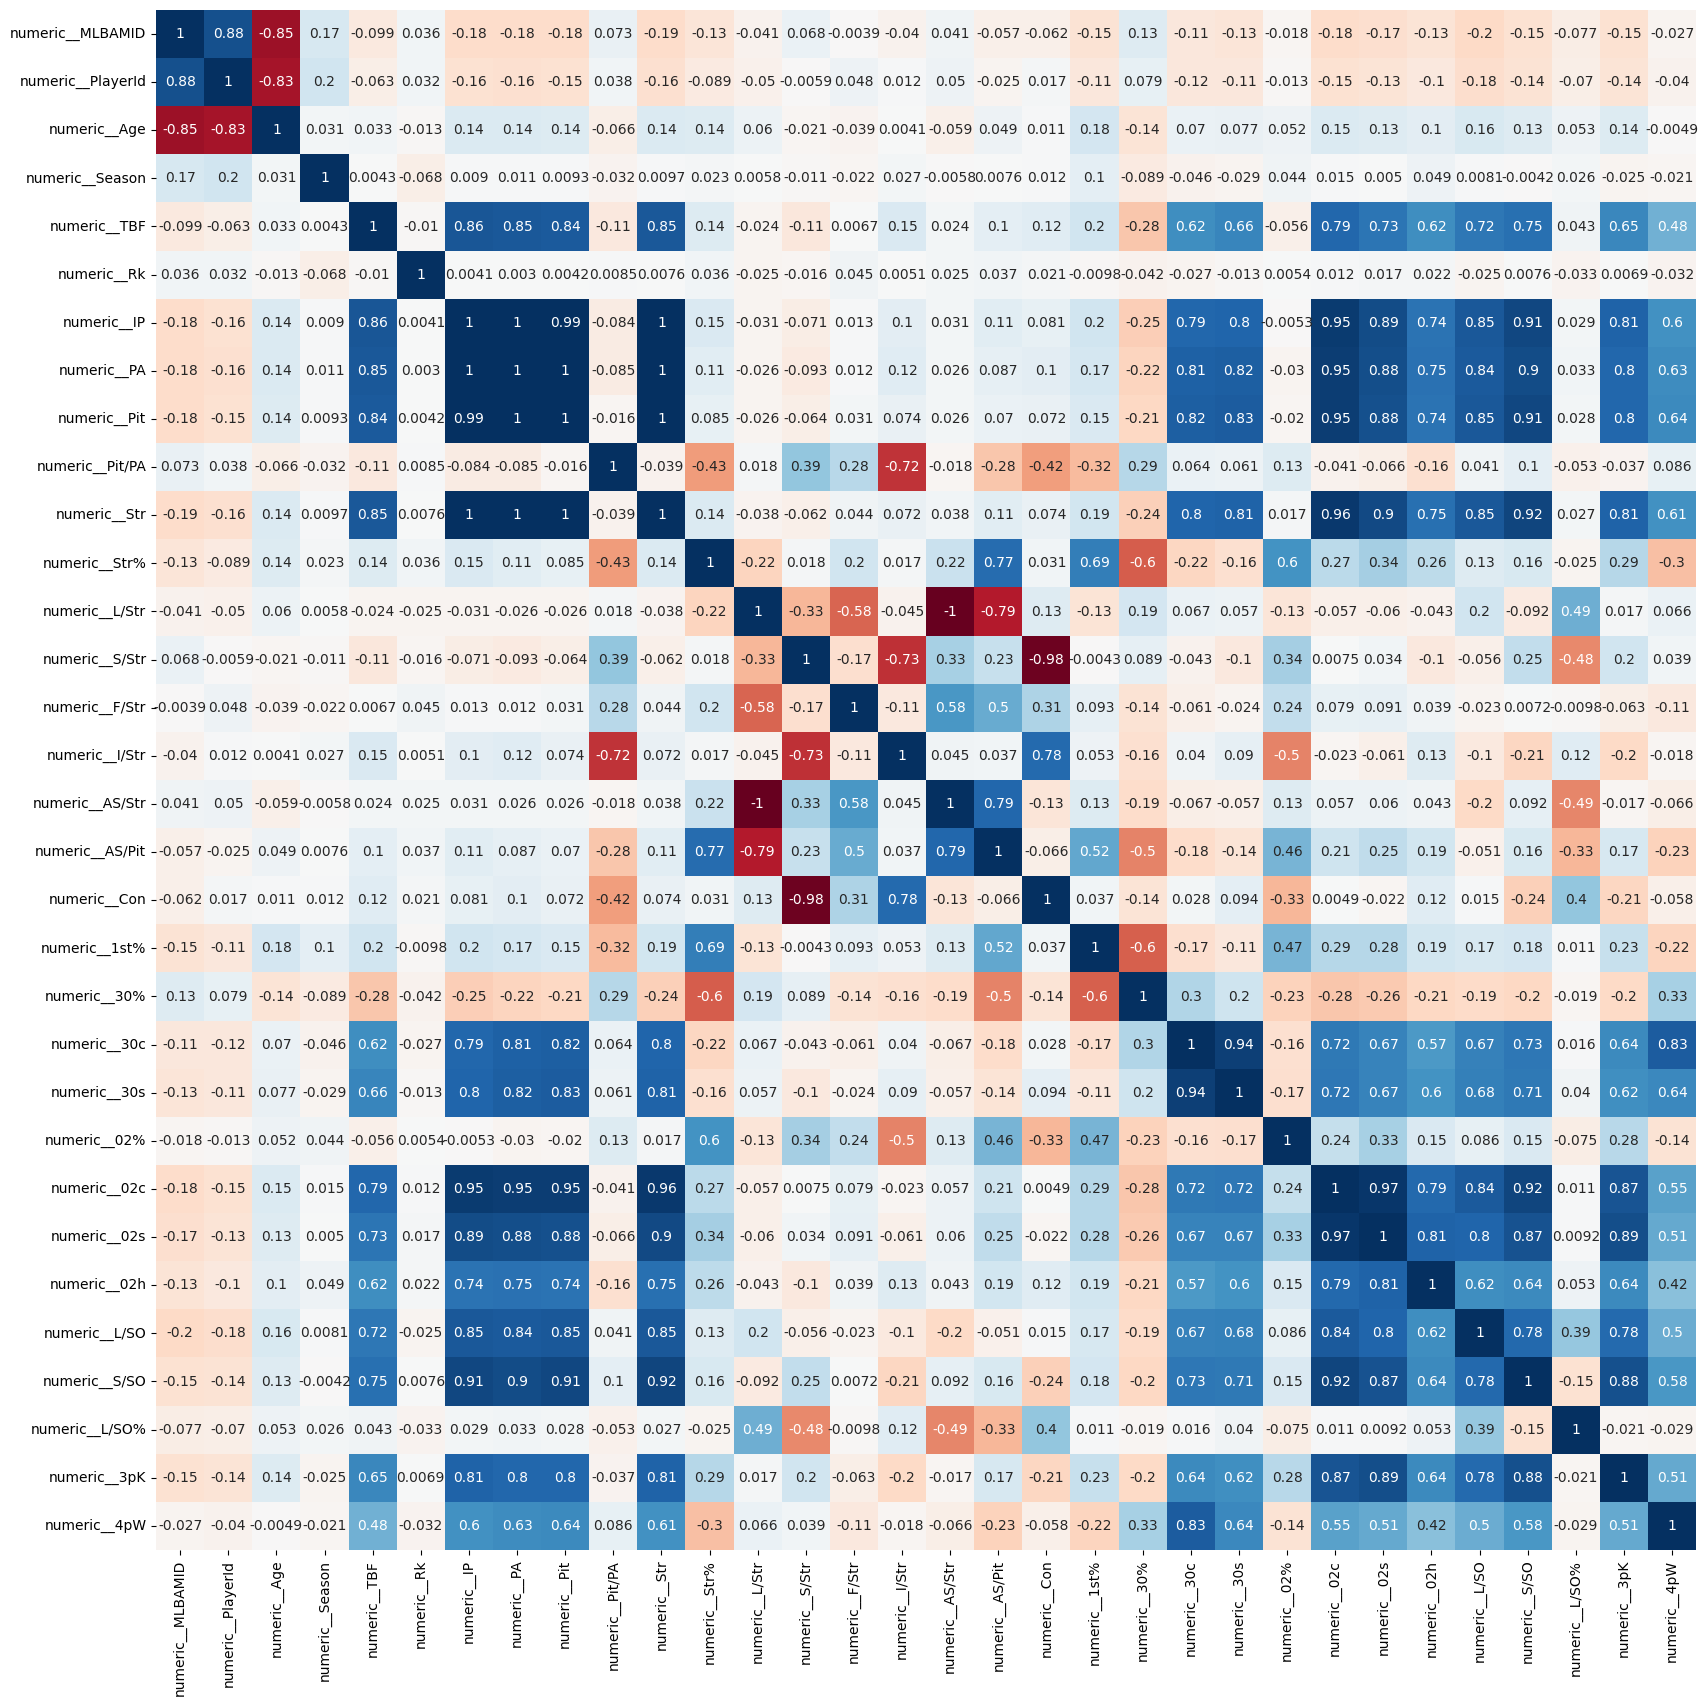

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

_ = sns.heatmap(
    corr.dropna(how="all").dropna(how="all", axis=1),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="RdBu",
    ax=ax,
    cbar=False,
    square=True,
)